# Step 2.1: Heterogeneous Treatment Effect (HTE) Analysis

This notebook implements Track 2 (Causal Targeting) HTE analysis:
- Treatment: First TypeA campaign targeting (clean causal identification)
- Control: Never targeted by TypeA
- Goal: Estimate CATE τ(x) = E[Y(1) - Y(0) | X=x]

**Analysis Structure:**
1. Setup & Data Loading
2. Exploratory Analysis (Balance, Propensity, Positivity)
3. ATE Estimation (5 methods)
4. CATE Estimation (6 models)
5. Validation & Metrics (BLP, AUUC, RATE)
6. Business Impact Analysis (Segment CATE, ROI, What-if)
7. Summary & Recommendations

---
## 1. Setup & Data Loading

In [ ]:
# Setup Python path
import sys
from pathlib import Path

# Add project root to path for module imports
PROJECT_ROOT = Path('.').absolute().parents[2]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Standard libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

# Econml - Causal ML
from econml.dml import LinearDML, CausalForestDML, NonParamDML
from econml.metalearners import SLearner, TLearner, XLearner
from econml.grf import CausalForest

# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Project modules - Treatment Effects
from projects.segmentation_dunnhumby.src import (
    # ATE Estimators
    estimate_ate_naive, estimate_ate_ipw, estimate_ate_aipw, 
    estimate_ate_ols, estimate_ate_dml, estimate_all_ate, estimate_ate_ato,
    # Propensity Score
    estimate_propensity_score, estimate_propensity_score_cv,
    # Positivity Diagnostics
    compute_positivity_diagnostics, compute_covariate_balance,
    # Trimming & Weighting
    apply_ps_trimming, compute_ato_weights,
    # Bounds & Sensitivity
    compute_ate_manski_bounds, positivity_sensitivity,
    # Confounder Analysis
    analyze_ps_feature_importance, run_covariate_experiment,
    # BLP Test
    blp_test,
    # Types
    ATEResult, PositivityDiagnostics,
)

# Project modules - Plots
from projects.segmentation_dunnhumby.src import (
    PlotConfig, setup_style,
    plot_ps_distribution, plot_ps_overlap,
    plot_love_plot, 
    plot_uplift_curve, plot_qini_curve, plot_cate_comparison,
    plot_uplift_with_auuc,
    plot_cate_by_segment, plot_cate_boxplot_by_segment,
    plot_trimming_sensitivity, plot_model_comparison_heatmap,
    plot_ate_comparison, plot_ate_forest,
    plot_covariate_experiment, plot_positivity_summary,
)

# Plot style
setup_style()

SEED = 42
np.random.seed(SEED)
print(f"Project root: {PROJECT_ROOT}")
print("Imports complete. Using modularized src/ modules.")

In [2]:
# Project paths
PROJECT_ROOT = Path('.').absolute().parents[2]
DATA_PATH = PROJECT_ROOT / 'data' / 'dunnhumby' / 'raw'
PROCESSED_PATH = PROJECT_ROOT / 'data' / 'dunnhumby' / 'processed'
RESULTS_PATH = PROJECT_ROOT / 'projects' / 'segmentation_dunnhumby' / 'results'
FIG_PATH = RESULTS_PATH / 'figures'
TABLE_PATH = RESULTS_PATH / 'tables'

FIG_PATH.mkdir(parents=True, exist_ok=True)
TABLE_PATH.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Results path: {RESULTS_PATH}")

Project root: /Users/taehyun/project/side-projects
Data path: /Users/taehyun/project/side-projects/data/dunnhumby/raw
Results path: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results


In [3]:
# Load raw data
df_trans = pd.read_csv(DATA_PATH / 'transaction_data.csv')
df_product = pd.read_csv(DATA_PATH / 'product.csv')
df_campaign_table = pd.read_csv(DATA_PATH / 'campaign_table.csv')
df_campaign_desc = pd.read_csv(DATA_PATH / 'campaign_desc.csv')
df_coupon = pd.read_csv(DATA_PATH / 'coupon.csv')
df_coupon_redempt = pd.read_csv(DATA_PATH / 'coupon_redempt.csv')
df_causal = pd.read_csv(DATA_PATH / 'causal_data.csv')
df_demo = pd.read_csv(DATA_PATH / 'hh_demographic.csv')

print(f"Transactions: {len(df_trans):,} rows")
print(f"Products: {len(df_product):,}")
print(f"Campaigns: {len(df_campaign_desc)}")

Transactions: 2,595,732 rows
Products: 92,353
Campaigns: 30


In [4]:
# Preprocess transactions
from data.dunnhumby.preprocess import preprocess_transactions
df_trans = preprocess_transactions(df_trans)
print(f"Preprocessed transactions: {len(df_trans):,} rows")

Preprocessed transactions: 2,581,260 rows


### 1.1 Build Scenario 1 Cohort & Features

**Scenario 1 (First TypeA Only)**:
- Treatment: Customer's FIRST TypeA campaign targeting
- Control: Never targeted by any TypeA campaign
- Each customer appears exactly once (clean causal identification)

In [5]:
# Build Scenario 1 features
from projects.segmentation_dunnhumby.src.features import build_scenario1_features

df_scenario1 = build_scenario1_features(
    df_trans, df_product, df_causal,
    df_campaign_table, df_campaign_desc,
    df_coupon_redempt, df_demo,
    post_window=4,  # Outcome window: campaign + 4 weeks
    first_campaign_only=True
)

print(f"Scenario 1 cohort: {len(df_scenario1):,} customers")
print(f"  Treatment: {df_scenario1['targeted'].sum():,} ({df_scenario1['targeted'].mean():.1%})")
print(f"  Control: {(1-df_scenario1['targeted']).sum():.0f} ({1-df_scenario1['targeted'].mean():.1%})")

Scenario 1 cohort: 2,430 customers
  Treatment: 1,511 (62.2%)
  Control: 919 (37.8%)


In [6]:
# Treatment distribution by campaign
print("\nTreatment by Campaign:")
display(df_scenario1.groupby('CAMPAIGN')['targeted'].agg(['sum', 'count', 'mean']).round(3))


Treatment by Campaign:


,sum,count,mean
CAMPAIGN,,,
8,768,838,0.916
13,153,192,0.797
18,132,155,0.852
26,332,985,0.337
30,126,260,0.485


### 1.2 Load Track 1 Segments

Load customer segment assignments from Track 1 (02_customer_profiling.ipynb).

In [7]:
# Load Track 1 segments from saved models
import joblib
from projects.segmentation_dunnhumby.src.features import build_all_features

SEGMENT_MODELS_PATH = PROCESSED_PATH / 'segment_models.joblib'

if SEGMENT_MODELS_PATH.exists():
    segment_models = joblib.load(SEGMENT_MODELS_PATH)
    SEGMENT_NAMES = segment_models['segment_names']
    FACTOR_NAMES = segment_models.get('factor_names', {})
    
    # Build Track 1 features to get household_key mapping
    df_track1_features = build_all_features(df_trans, df_product)
    
    df_segments = pd.DataFrame({
        'household_key': df_track1_features['household_key'],
        'segment': segment_models['segment_labels']
    })
    df_segments['segment_name'] = df_segments['segment'].map(SEGMENT_NAMES)
    
    print(f"Loaded Track 1 Segments from: {SEGMENT_MODELS_PATH}")
    print(f"\nSegment Distribution:")
    print(df_segments['segment_name'].value_counts())
else:
    print("Warning: segment_models.joblib not found.")
    print("Run 02_customer_profiling.ipynb first for reproducibility.")
    SEGMENT_NAMES = {i: f'Segment_{i}' for i in range(7)}
    df_segments = None

Run 02_customer_profiling.ipynb first for reproducibility.


In [8]:
# Merge segments with Scenario 1 data
if df_segments is not None:
    df_scenario1 = df_scenario1.merge(
        df_segments[['household_key', 'segment', 'segment_name']], 
        on='household_key', 
        how='left'
    )
    print(f"Merged segments: {df_scenario1['segment_name'].notna().sum():,} customers with segment")
else:
    df_scenario1['segment'] = 0
    df_scenario1['segment_name'] = 'Unknown'

### 1.3 Define Analysis Variables

In [9]:
# Treatment
T = df_scenario1['targeted'].values

# Outcomes
Y_purchase = df_scenario1['purchase_amount'].values  # Continuous: purchase amount
Y_visits = df_scenario1['purchase_count'].values     # Count: visit count

OUTCOMES = [
    ('purchase_amount', 'Purchase Amount ($)', Y_purchase),
    ('purchase_count', 'Visit Count', Y_visits)
]

# Covariates (confounders) - ordered by importance
COVARIATE_COLS = [
    # RFM Core
    'recency', 'frequency', 'monetary_sales',
    'frequency_per_week', 'monetary_avg_basket_sales', 'purchase_regularity',
    # RFM Extended
    'days_between_purchases_avg', 'monetary_std', 'coupon_savings_ratio',
    # Behavioral
    'discount_usage_pct', 'private_label_ratio',
    'n_departments', 'n_products', 'avg_items_per_basket',
    # Category shares
    'share_grocery', 'share_fresh', 'share_bakery', 'share_health_beauty', 'share_alcohol',
    # Marketing exposure
    'display_exposure_rate', 'mailer_exposure_rate',
]

# Filter to available columns
available_covariates = [c for c in COVARIATE_COLS if c in df_scenario1.columns]
print(f"Available covariates: {len(available_covariates)}/{len(COVARIATE_COLS)}")

# Build covariate matrix
X = df_scenario1[available_covariates].fillna(0).values
covariate_columns = available_covariates

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nData shapes:")
print(f"  X: {X.shape}")
print(f"  T: {T.shape}, mean={T.mean():.3f}")
print(f"  Y_purchase: {Y_purchase.shape}, mean=${Y_purchase.mean():.2f}")
print(f"  Y_visits: {Y_visits.shape}, mean={Y_visits.mean():.2f}")

Available covariates: 21/21

Data shapes:
  X: (2430, 21)
  T: (2430,), mean=0.622
  Y_purchase: (2430,), mean=$433.21
  Y_visits: (2430,), mean=14.87


### 1.4 Train/Test Split

80/20 stratified split for fair model comparison:
- **Train (80%)**: Fit all CATE models
- **Test (20%)**: Model selection (AUUC) and validation (RATE)

In [10]:
# Stratified split
train_idx, test_idx = train_test_split(
    np.arange(len(T)), 
    test_size=0.2, 
    stratify=T,
    random_state=SEED
)

# Train data
X_train, T_train = X[train_idx], T[train_idx]
X_train_scaled = X_scaled[train_idx]
Y_purchase_train = Y_purchase[train_idx]
Y_visits_train = Y_visits[train_idx]

# Test data
X_test, T_test = X[test_idx], T[test_idx]
X_test_scaled = X_scaled[test_idx]
Y_purchase_test = Y_purchase[test_idx]
Y_visits_test = Y_visits[test_idx]

# Full data references
X_full, T_full = X, T
X_full_scaled = X_scaled
Y_purchase_full = Y_purchase
Y_visits_full = Y_visits

print(f"Train: {len(train_idx):,} ({len(train_idx)/len(T):.1%})")
print(f"  Treated: {T_train.sum():,} ({T_train.mean():.1%})")
print(f"Test: {len(test_idx):,} ({len(test_idx)/len(T):.1%})")
print(f"  Treated: {T_test.sum():,} ({T_test.mean():.1%})")

Train: 1,944 (80.0%)
  Treated: 1,209 (62.2%)
Test: 486 (20.0%)
  Treated: 302 (62.1%)


---
## 2. Exploratory Analysis

### 2.1 Treatment/Control Balance Check

Check covariate balance using Standardized Mean Difference (SMD).
- |SMD| < 0.1: Good balance
- |SMD| 0.1-0.25: Moderate imbalance
- |SMD| > 0.25: Severe imbalance

In [14]:
# Covariate balance using module function
df_balance = compute_covariate_balance(
    X=pd.DataFrame(X_full, columns=covariate_columns),
    T=T_full
)

# Summary
n_balanced = (df_balance['smd'].abs() < 0.1).sum()
n_moderate = ((df_balance['smd'].abs() >= 0.1) & (df_balance['smd'].abs() < 0.25)).sum()
n_severe = (df_balance['smd'].abs() >= 0.25).sum()

print(f"Covariate Balance Summary:")
print(f"  Balanced (|SMD| < 0.1): {n_balanced}/{len(df_balance)}")
print(f"  Moderate (0.1 <= |SMD| < 0.25): {n_moderate}/{len(df_balance)}")
print(f"  Severe (|SMD| >= 0.25): {n_severe}/{len(df_balance)}")

display(df_balance.sort_values('smd', key=abs, ascending=False))

Covariate Balance Summary:
  Balanced (|SMD| < 0.1): 9/21
  Moderate (0.1 <= |SMD| < 0.25): 2/21
  Severe (|SMD| >= 0.25): 10/21


,feature,mean_treated,mean_control,std_treated,std_control,smd,abs_smd,balanced
11,n_departments,11.855063,6.674646,2.705151,2.497816,1.989752,1.989752,False
5,purchase_regularity,0.714490,0.310904,0.191753,0.214184,1.985385,1.985385,False
12,n_products,427.828590,80.622416,250.350728,76.157717,1.876441,1.876441,False
2,monetary_sales,2179.067379,297.744037,1708.798946,373.526384,1.521080,1.521080,False
1,frequency,76.070152,12.362350,66.303828,15.233130,1.324340,1.324340,False
3,frequency_per_week,1.724637,0.521446,1.450550,0.690315,1.059221,1.059221,False
6,days_between_purchases_avg,6.818491,28.355963,3.959601,36.415958,-0.831507,0.831507,False
0,recency,7.154864,48.194777,12.907802,81.744554,-0.701318,0.701318,False
7,monetary_std,29.976396,22.068710,16.780899,18.567673,0.446841,0.446841,False
13,avg_items_per_basket,788.175486,449.765872,1191.348073,1293.236770,0.272179,0.272179,False


AttributeError: 'Axes' object has no attribute 'savefig'

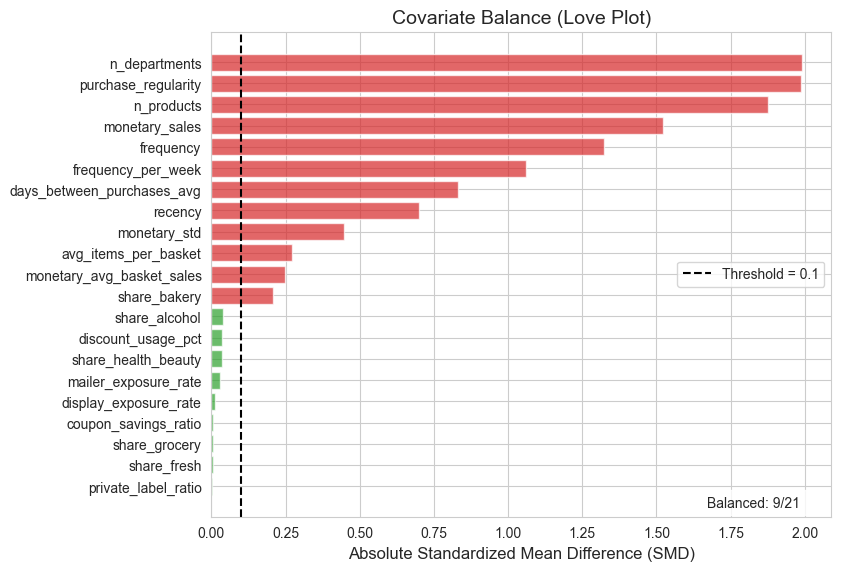

In [15]:
# Love plot
fig = plot_love_plot(df_balance, threshold=0.1)
fig.savefig(FIG_PATH / 'covariate_balance.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Propensity Score Analysis

In [16]:
# Estimate propensity scores (cross-validated on train, predict on test)
ps_train = estimate_propensity_score_cv(X_train, T_train, cv=5)
ps_test = estimate_propensity_score(X_train, T_train, X_test)
ps_full = estimate_propensity_score_cv(X_full, T_full, cv=5)

print(f"Propensity Score Statistics:")
print(f"  Train: mean={ps_train.mean():.3f}, range=[{ps_train.min():.3f}, {ps_train.max():.3f}]")
print(f"  Test:  mean={ps_test.mean():.3f}, range=[{ps_test.min():.3f}, {ps_test.max():.3f}]")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [17]:
# PS distribution plot
fig = plot_ps_distribution(ps_train, ps_test, T_train, T_test)
fig.savefig(FIG_PATH / 'propensity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# PS overlap plot
fig = plot_ps_overlap(ps_full, T_full)
fig.savefig(FIG_PATH / 'propensity_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

NameError: name 'ps_test' is not defined

### 2.3 Positivity Assumption Analysis

**Positivity Assumption (Overlap Condition):**
```
0 < P(T=1|X=x) < 1 for all x with positive density
```

This requires that every covariate combination has a positive probability of receiving both treatment and control.

In [18]:
# Positivity diagnostics using module function
diagnostics = compute_positivity_diagnostics(ps_train, ps_test, T_train, T_test)

print("=" * 60)
print("POSITIVITY DIAGNOSTICS")
print("=" * 60)
print(f"\n[Propensity Score AUC]")
print(f"  Train: {diagnostics.ps_auc_train:.3f}")
print(f"  Test:  {diagnostics.ps_auc_test:.3f}")

severity = 'SEVERE' if diagnostics.ps_auc_train > 0.9 else 'WARNING' if diagnostics.ps_auc_train > 0.7 else 'OK'
print(f"  Status: {severity}")

print(f"\n[Overlap Ratios]")
print(f"  PS in [0.1, 0.9]: {diagnostics.overlap_ratio_10_90:.1%}")
print(f"  PS in [0.05, 0.95]: {diagnostics.overlap_ratio_05_95:.1%}")

print(f"\n[PS Range by Group]")
print(f"  Treated: [{diagnostics.ps_range_treated[0]:.3f}, {diagnostics.ps_range_treated[1]:.3f}]")
print(f"  Control: [{diagnostics.ps_range_control[0]:.3f}, {diagnostics.ps_range_control[1]:.3f}]")

# Summary plot
fig = plot_positivity_summary(diagnostics, ps_full, T_full)
fig.savefig(FIG_PATH / 'positivity_summary.png', dpi=150, bbox_inches='tight')
plt.show()

NameError: name 'ps_test' is not defined

#### Implications of Positivity Violation

**Current situation**: PS AUC ≈ 0.99 indicates severe positivity violation:
- Treatment and Control groups are almost perfectly separable
- CATE estimates in extreme PS regions are model-dependent extrapolations
- ATE estimates will vary significantly across methods

**Consequences:**
1. ATE estimates unstable (can vary 20x across methods)
2. CATE models may disagree on effect direction
3. Business recommendations should focus on overlap region only

### 2.4 Trimming & ATO Experiments

Compare ATE estimates under different positivity correction methods:
1. **No Trimming**: Full data (baseline)
2. **PS Trimming**: Exclude extreme PS values
3. **ATO (Overlap Weighting)**: Weight by h(e) = e*(1-e)

In [20]:
# Trimming experiments
print("=" * 70)
print("TRIMMING & ATO EXPERIMENTS")
print("=" * 70)

trim_levels = [0.0, 0.05, 0.1, 0.15, 0.2]
results = []

for thresh in trim_levels:
    if thresh == 0.0:
        Y_trim, T_trim, X_trim = Y_purchase_full, T_full, X_full
        method = "Full (no trim)"
    else:
        mask = apply_ps_trimming(ps_full, lower=thresh, upper=1-thresh)
        Y_trim = Y_purchase_full[mask]
        T_trim = T_full[mask]
        X_trim = X_full[mask]
        method = f"Trim [{thresh:.2f}, {1-thresh:.2f}]"
    
    n_remaining = len(Y_trim)
    pct_remaining = n_remaining / len(Y_purchase_full) * 100
    
    try:
        ate_result = estimate_ate_dml(Y_trim, T_trim, X_trim)
        results.append({
            'method': method, 'threshold': thresh,
            'n': n_remaining, 'pct': pct_remaining,
            'ate': ate_result.estimate, 'se': ate_result.se,
        })
    except Exception as e:
        results.append({
            'method': method, 'threshold': thresh,
            'n': n_remaining, 'pct': pct_remaining,
            'ate': np.nan, 'se': np.nan,
        })

# ATO estimate
ato_result = estimate_ate_ato(Y_purchase_full, T_full, ps_full)
results.append({
    'method': 'ATO (Overlap Weighting)', 'threshold': np.nan,
    'n': len(Y_purchase_full), 'pct': 100.0,
    'ate': ato_result.estimate, 'se': ato_result.se,
})

df_trimming = pd.DataFrame(results)
display(df_trimming)

TRIMMING & ATO EXPERIMENTS


NameError: name 'ps_full' is not defined

NameError: name 'df_trimming' is not defined

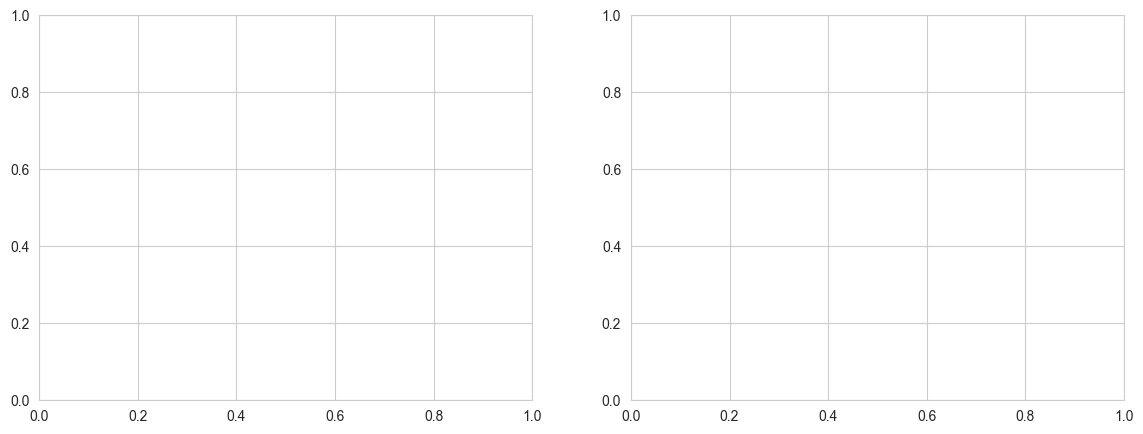

In [21]:
# Visualize trimming effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ATE by trimming threshold
ax = axes[0]
df_plot = df_trimming[df_trimming['threshold'].notna()].copy()
ax.errorbar(df_plot['threshold'], df_plot['ate'], yerr=1.96*df_plot['se'], fmt='o-', capsize=5)
ato_ate = df_trimming[df_trimming['method'].str.contains('ATO')]['ate'].values[0]
ax.axhline(y=ato_ate, color='red', linestyle='--', label=f'ATO: ${ato_ate:.2f}')
ax.set_xlabel('Trimming Threshold')
ax.set_ylabel('ATE Estimate ($)')
ax.set_title('ATE by Trimming Threshold')
ax.legend()

# Sample size
ax = axes[1]
ax.bar(range(len(df_trimming)), df_trimming['pct'])
ax.set_xticks(range(len(df_trimming)))
ax.set_xticklabels(df_trimming['method'], rotation=45, ha='right')
ax.set_ylabel('% of Sample Remaining')
ax.set_title('Sample Size by Method')

plt.tight_layout()
fig.savefig(FIG_PATH / 'trimming_effects.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.5 Outcome Distributions

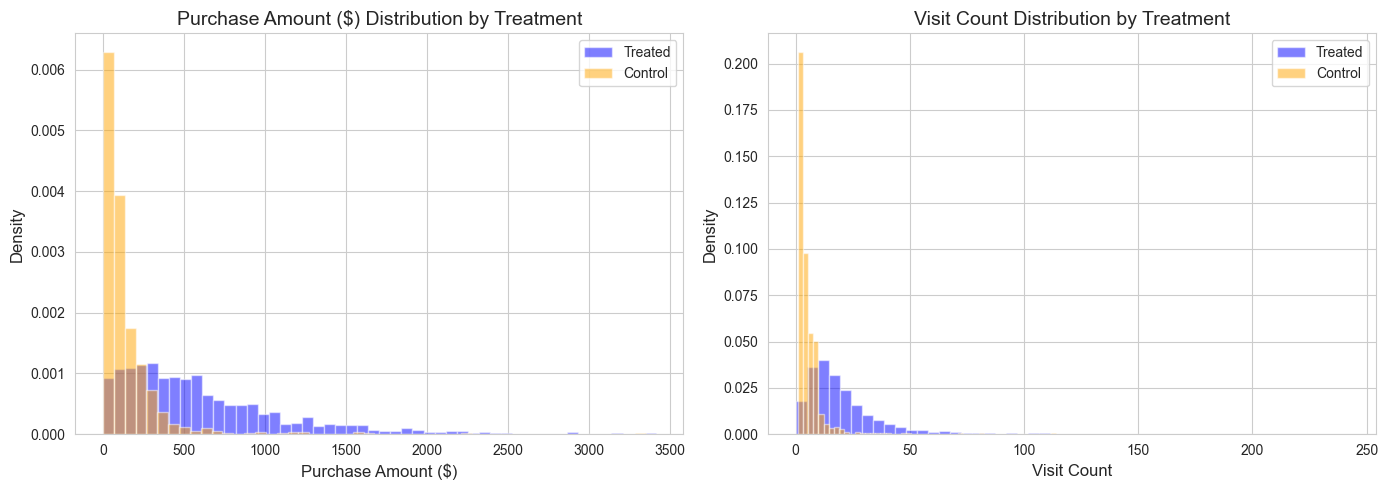

Naive ATE (unadjusted):
  Purchase Amount ($): $471.44 (p=0.0000)
  Visit Count: $15.34 (p=0.0000)


In [22]:
# Outcome by treatment status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (col, title, Y) in zip(axes, OUTCOMES):
    for t_val, label, color in [(1, 'Treated', 'blue'), (0, 'Control', 'orange')]:
        ax.hist(Y[T_full == t_val], bins=50, alpha=0.5, label=label, color=color, density=True)
    ax.set_xlabel(title)
    ax.set_ylabel('Density')
    ax.set_title(f'{title} Distribution by Treatment')
    ax.legend()

plt.tight_layout()
fig.savefig(FIG_PATH / 'outcome_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# Naive ATE
print("Naive ATE (unadjusted):")
for col, name, Y in OUTCOMES:
    treated_mean = Y[T_full == 1].mean()
    control_mean = Y[T_full == 0].mean()
    naive_ate = treated_mean - control_mean
    t_stat, p_val = stats.ttest_ind(Y[T_full == 1], Y[T_full == 0])
    print(f"  {name}: ${naive_ate:.2f} (p={p_val:.4f})")

---
## 3. ATE Estimation

Compare 5 methods for Average Treatment Effect estimation:
1. **Naive**: Simple mean difference (biased)
2. **IPW**: Inverse Propensity Weighting
3. **AIPW**: Augmented IPW (Doubly Robust)
4. **OLS**: Linear regression with covariates
5. **DML**: Double Machine Learning

In [23]:
# Estimate ATE using all methods (Full dataset)
print("=" * 70)
print("ATE ESTIMATION (Full Dataset)")
print("=" * 70)

ate_results = {}
for outcome_name, outcome_label, Y_outcome in OUTCOMES:
    Y_full_outcome = Y_outcome  # Already full
    ate_results[outcome_name] = estimate_all_ate(Y_full_outcome, T_full, X_full, ps_full)
    
    print(f"\n[{outcome_label}]")
    for method, result in ate_results[outcome_name].items():
        ci_str = f"[{result.ci_lower:.2f}, {result.ci_upper:.2f}]" if result.ci_lower is not None else "N/A"
        print(f"  {method:8s}: {result.estimate:>8.2f} (SE: {result.se:.2f}) 95% CI: {ci_str}")

ATE ESTIMATION (Full Dataset)


NameError: name 'ps_full' is not defined

KeyError: 'method'

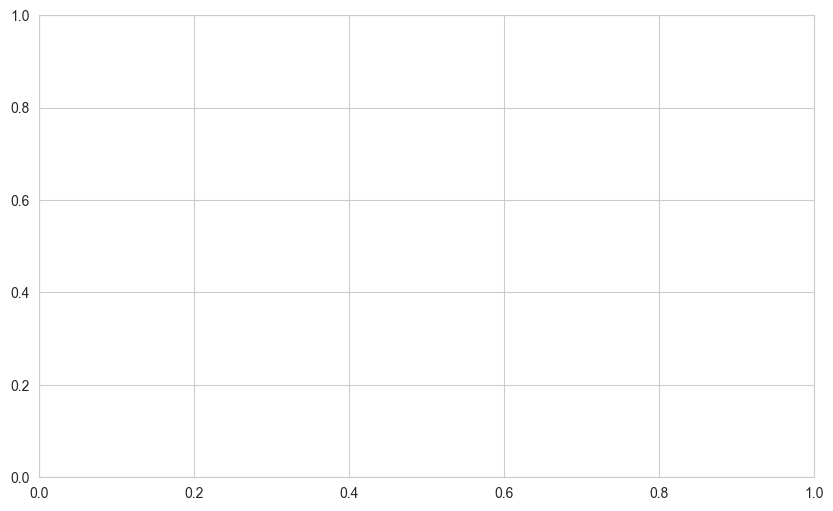

In [24]:
# ATE comparison plot
fig = plot_ate_comparison(ate_results)
fig.savefig(FIG_PATH / 'ate_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Forest plot
fig = plot_ate_forest(ate_results)
fig.savefig(FIG_PATH / 'ate_forest.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
# Partial Identification: Manski Bounds
print("=" * 70)
print("PARTIAL IDENTIFICATION: ATE MANSKI BOUNDS")
print("=" * 70)

for outcome_name, outcome_label, Y_outcome in OUTCOMES:
    bounds = compute_ate_manski_bounds(Y_outcome, T_full)
    dml_est = ate_results[outcome_name]['DML'].estimate
    
    print(f"\n[{outcome_label}]")
    print(f"  Point Estimate (DML): {dml_est:.2f}")
    print(f"  Manski Bounds: [{bounds.lower:.2f}, {bounds.upper:.2f}]")
    print(f"  Width: {bounds.upper - bounds.lower:.2f}")

PARTIAL IDENTIFICATION: ATE MANSKI BOUNDS


KeyError: 'purchase_amount'

---
## 4. CATE Estimation

Estimate Conditional Average Treatment Effects using multiple models:
- **Baseline**: S-Learner, T-Learner, X-Learner
- **Main (DML-based)**: LinearDML, CausalForestDML, NonParamDML
- **Comparison**: CausalForest (GRF)

In [26]:
# Setup CATE model training
# Store results in nested dict: {outcome: {model: predictions}}
cate_results_train = {'purchase_amount': {}, 'purchase_count': {}}
cate_results_test = {'purchase_amount': {}, 'purchase_count': {}}
cate_models = {'purchase_amount': {}, 'purchase_count': {}}  # Store fitted models

CATE_OUTCOMES = [
    ('purchase_amount', 'Purchase Amount ($)', Y_purchase_train, Y_purchase_test),
    ('purchase_count', 'Visit Count', Y_visits_train, Y_visits_test),
]

print("CATE Model Training Setup:")
print(f"  Outcomes: {[o[0] for o in CATE_OUTCOMES]}")
print(f"  Train size: {len(T_train)}")
print(f"  Test size: {len(T_test)}")

CATE Model Training Setup:
  Outcomes: ['purchase_amount', 'purchase_count']
  Train size: 1944
  Test size: 486


### 4.1 Baseline: Classic Meta-Learners (S/T/X-Learner)

Classic meta-learners as baseline. Known issues with high PS AUC:
- S-Learner: May underestimate HTE
- T-Learner: High variance, extrapolation issues
- X-Learner: Better than T, but still extrapolation-dependent

In [27]:
# Train baseline meta-learners
print("=" * 70)
print("BASELINE META-LEARNERS")
print("=" * 70)

for outcome_name, outcome_label, Y_train, Y_test in CATE_OUTCOMES:
    print(f"\n[{outcome_label}]")
    
    # S-Learner
    print("  Training S-Learner...", end=" ")
    slearner = SLearner(
        overall_model=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED)
    )
    slearner.fit(Y_train, T_train, X=X_train)
    cate_results_train[outcome_name]['S-Learner'] = slearner.effect(X_train).flatten()
    cate_results_test[outcome_name]['S-Learner'] = slearner.effect(X_test).flatten()
    cate_models[outcome_name]['S-Learner'] = slearner
    print(f"Test CATE mean: ${cate_results_test[outcome_name]['S-Learner'].mean():.2f}")
    
    # T-Learner
    print("  Training T-Learner...", end=" ")
    tlearner = TLearner(
        models=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED)
    )
    tlearner.fit(Y_train, T_train, X=X_train)
    cate_results_train[outcome_name]['T-Learner'] = tlearner.effect(X_train).flatten()
    cate_results_test[outcome_name]['T-Learner'] = tlearner.effect(X_test).flatten()
    cate_models[outcome_name]['T-Learner'] = tlearner
    print(f"Test CATE mean: ${cate_results_test[outcome_name]['T-Learner'].mean():.2f}")
    
    # X-Learner
    print("  Training X-Learner...", end=" ")
    xlearner = XLearner(
        models=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED),
        propensity_model=LogisticRegression(max_iter=1000)
    )
    xlearner.fit(Y_train, T_train, X=X_train)
    cate_results_train[outcome_name]['X-Learner'] = xlearner.effect(X_train).flatten()
    cate_results_test[outcome_name]['X-Learner'] = xlearner.effect(X_test).flatten()
    cate_models[outcome_name]['X-Learner'] = xlearner
    print(f"Test CATE mean: ${cate_results_test[outcome_name]['X-Learner'].mean():.2f}")

print("\nBaseline meta-learners training complete.")

BASELINE META-LEARNERS

[Purchase Amount ($)]
  Training S-Learner... Test CATE mean: $-20.58
  Training T-Learner... Test CATE mean: $-200.10
  Training X-Learner... Test CATE mean: $-95.58

[Visit Count]
  Training S-Learner... Test CATE mean: $0.54
  Training T-Learner... Test CATE mean: $0.13
  Training X-Learner... Test CATE mean: $1.29

Baseline meta-learners training complete.


### 4.2 Main: DML-based Models (R-Learner Implementations)

DML (Double/Debiased Machine Learning) models implement the **R-Learner** framework:
1. Cross-fit nuisance models (outcome, propensity)
2. Orthogonalize treatment effect estimation
3. Final stage: linear, forest, or nonparametric

**Advantages:**
- Robust to nuisance model misspecification (doubly robust)
- Valid inference via cross-fitting
- Handles high-dimensional confounders

In [28]:
# Train DML-based models (Main models)
print("=" * 70)
print("DML-BASED MODELS (R-LEARNER IMPLEMENTATIONS)")
print("=" * 70)

for outcome_name, outcome_label, Y_train, Y_test in CATE_OUTCOMES:
    print(f"\n[{outcome_label}]")
    
    # LinearDML - R-Learner + linear final stage
    print("  Training LinearDML...", end=" ")
    linear_dml = LinearDML(
        model_y=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED),
        model_t=LogisticRegression(C=1.0, max_iter=1000),
        discrete_treatment=True,
        cv=5,
        random_state=SEED
    )
    linear_dml.fit(Y_train, T_train, X=X_train)
    cate_results_train[outcome_name]['LinearDML'] = linear_dml.effect(X_train).flatten()
    cate_results_test[outcome_name]['LinearDML'] = linear_dml.effect(X_test).flatten()
    cate_models[outcome_name]['LinearDML'] = linear_dml
    print(f"Test CATE mean: ${cate_results_test[outcome_name]['LinearDML'].mean():.2f}")
    
    # CausalForestDML - R-Learner + causal forest final stage
    print("  Training CausalForestDML...", end=" ")
    cf_dml = CausalForestDML(
        model_y=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED),
        model_t=LogisticRegression(C=1.0, max_iter=1000),
        discrete_treatment=True,
        n_estimators=200,
        min_samples_leaf=20,
        cv=5,
        random_state=SEED
    )
    cf_dml.fit(Y_train, T_train, X=X_train)
    cate_results_train[outcome_name]['CausalForestDML'] = cf_dml.effect(X_train).flatten()
    cate_results_test[outcome_name]['CausalForestDML'] = cf_dml.effect(X_test).flatten()
    cate_models[outcome_name]['CausalForestDML'] = cf_dml
    print(f"Test CATE mean: ${cate_results_test[outcome_name]['CausalForestDML'].mean():.2f}")
    
    # NonParamDML - R-Learner + nonparametric final
    print("  Training NonParamDML...", end=" ")
    nonparam_dml = NonParamDML(
        model_y=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED),
        model_t=LogisticRegression(C=1.0, max_iter=1000),
        model_final=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=SEED),
        discrete_treatment=True,
        cv=5,
        random_state=SEED
    )
    nonparam_dml.fit(Y_train, T_train, X=X_train)
    cate_results_train[outcome_name]['NonParamDML'] = nonparam_dml.effect(X_train).flatten()
    cate_results_test[outcome_name]['NonParamDML'] = nonparam_dml.effect(X_test).flatten()
    cate_models[outcome_name]['NonParamDML'] = nonparam_dml
    print(f"Test CATE mean: ${cate_results_test[outcome_name]['NonParamDML'].mean():.2f}")

print("\nDML-based models training complete.")

DML-BASED MODELS (R-LEARNER IMPLEMENTATIONS)

[Purchase Amount ($)]
  Training LinearDML... Test CATE mean: $-139.47
  Training CausalForestDML... Test CATE mean: $14.97
  Training NonParamDML... Test CATE mean: $1146028.98

[Visit Count]
  Training LinearDML... Test CATE mean: $-2.95
  Training CausalForestDML... Test CATE mean: $0.79
  Training NonParamDML... Test CATE mean: $12122.33

DML-based models training complete.


### 4.3 Comparison: CausalForest (GRF)

Standard Generalized Random Forest (GRF) without DML wrapper.
- Direct forest-based CATE estimation
- No explicit nuisance model orthogonalization
- Included for comparison purposes

In [29]:
# Train CausalForest (GRF) for comparison
print("=" * 70)
print("CAUSAL FOREST (GRF) - COMPARISON")
print("=" * 70)

for outcome_name, outcome_label, Y_train, Y_test in CATE_OUTCOMES:
    print(f"\n[{outcome_label}]")
    print("  Training CausalForest_GRF...", end=" ")
    
    cf_grf = CausalForest(
        n_estimators=200,
        min_samples_leaf=20,
        random_state=SEED
    )
    cf_grf.fit(X_train, T_train, Y_train)
    cate_results_train[outcome_name]['CausalForest_GRF'] = cf_grf.predict(X_train).flatten()
    cate_results_test[outcome_name]['CausalForest_GRF'] = cf_grf.predict(X_test).flatten()
    cate_models[outcome_name]['CausalForest_GRF'] = cf_grf
    print(f"Test CATE mean: ${cate_results_test[outcome_name]['CausalForest_GRF'].mean():.2f}")

print("\nAll CATE models training complete!")

CAUSAL FOREST (GRF) - COMPARISON

[Purchase Amount ($)]
  Training CausalForest_GRF... Test CATE mean: $-60.69

[Visit Count]
  Training CausalForest_GRF... Test CATE mean: $7.62

All CATE models training complete!


### 4.4 CATE Model Summary

In [30]:
# Summarize all CATE models
print("=" * 70)
print("CATE MODEL SUMMARY")
print("=" * 70)

cate_summaries = {}
for outcome_name in ['purchase_amount', 'purchase_count']:
    rows = []
    for model_name in cate_results_test[outcome_name].keys():
        cate_train = cate_results_train[outcome_name][model_name]
        cate_test = cate_results_test[outcome_name][model_name]
        
        # Determine category
        if model_name in ['S-Learner', 'T-Learner', 'X-Learner']:
            category = 'Baseline'
        elif 'DML' in model_name:
            category = 'Main-DML'
        else:
            category = 'Comparison'
        
        rows.append({
            'Model': model_name,
            'Category': category,
            'Train_Mean': cate_train.mean(),
            'Test_Mean': cate_test.mean(),
            'Train_Std': cate_train.std(),
            'Test_Std': cate_test.std(),
            'Pct_Positive': (cate_test > 0).mean() * 100
        })
    
    cate_summaries[outcome_name] = pd.DataFrame(rows)
    print(f"\n[{outcome_name}]")
    display(cate_summaries[outcome_name])

CATE MODEL SUMMARY

[purchase_amount]


,Model,Category,Train_Mean,Test_Mean,Train_Std,Test_Std,Pct_Positive
0,S-Learner,Baseline,-22.157252,-2.058435e+01,4.981863e+01,4.645058e+01,0.205761
1,T-Learner,Baseline,-207.615668,-2.001022e+02,4.227355e+02,3.970561e+02,43.415638
2,X-Learner,Baseline,-93.663513,-9.557814e+01,2.005583e+02,2.079214e+02,38.477366
3,LinearDML,Main-DML,-149.603803,-1.394748e+02,4.687701e+02,4.523313e+02,41.769547
4,CausalForestDML,Main-DML,17.270842,1.497077e+01,5.105935e+01,5.214824e+01,77.983539
5,NonParamDML,Main-DML,682271.601502,1.146029e+06,8.598844e+06,1.020417e+07,63.786008
6,CausalForest_GRF,Comparison,-63.194952,-6.068984e+01,2.598905e+02,2.513058e+02,64.609053



[purchase_count]


,Model,Category,Train_Mean,Test_Mean,Train_Std,Test_Std,Pct_Positive
0,S-Learner,Baseline,0.546754,0.539912,0.861922,0.894497,74.074074
1,T-Learner,Baseline,0.266351,0.130800,12.289826,9.848318,64.197531
2,X-Learner,Baseline,1.632683,1.292969,5.402682,5.083414,61.111111
3,LinearDML,Main-DML,-3.161355,-2.945330,12.171416,11.689993,44.032922
4,CausalForestDML,Main-DML,0.696695,0.786601,2.674011,2.622584,85.390947
5,NonParamDML,Main-DML,12697.186843,12122.325287,216767.122781,184204.076655,62.345679
6,CausalForest_GRF,Comparison,7.343399,7.616575,4.629372,4.952235,100.000000


AttributeError: 'Axes' object has no attribute 'suptitle'

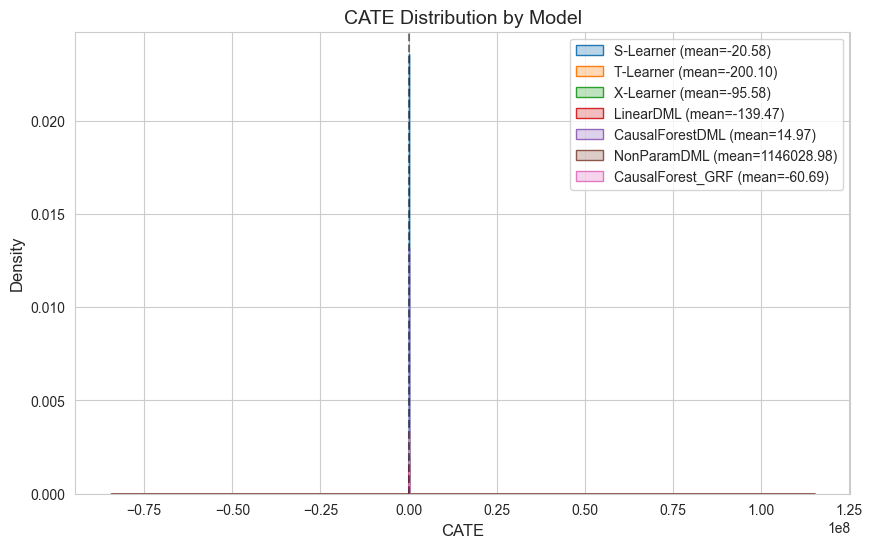

In [31]:
# CATE distribution comparison
for outcome_name in ['purchase_amount', 'purchase_count']:
    fig = plot_cate_comparison(cate_results_test[outcome_name])
    fig.suptitle(f'CATE Distribution Comparison - {outcome_name}', y=1.02)
    fig.savefig(FIG_PATH / f'cate_comparison_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Model correlation heatmap
for outcome_name in ['purchase_amount', 'purchase_count']:
    fig = plot_model_comparison_heatmap(cate_results_test[outcome_name])
    fig.savefig(FIG_PATH / f'cate_correlation_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 5. HTE Validation & Uplift Metrics

### 5.1 BLP Test for Heterogeneity

The BLP (Best Linear Prediction) test checks if there's significant treatment effect heterogeneity:
- H0: τ(x) = τ (constant treatment effect)
- H1: τ(x) varies with x

Test statistic: Regress (Y - E[Y|X]) on (T - e(X)) * (τ̂(x) - mean(τ̂))

In [32]:
# BLP Test using module function
print("=" * 70)
print("BLP TEST FOR HETEROGENEITY")
print("=" * 70)

blp_results = {}
for outcome_name, outcome_label, _, Y_test in CATE_OUTCOMES:
    # Use best DML model for BLP test
    if 'CausalForestDML' in cate_results_test[outcome_name]:
        model_name = 'CausalForestDML'
    else:
        model_name = list(cate_results_test[outcome_name].keys())[0]
    
    cate_preds = cate_results_test[outcome_name][model_name]
    
    blp_result = blp_test(
        Y=Y_test,
        T=T_test,
        X=X_test,
        cate_predictions=cate_preds,
        cv=5
    )
    blp_results[outcome_name] = blp_result
    
    print(f"\n[{outcome_label}] (Model: {model_name})")
    print(f"  tau_1 coefficient: {blp_result['tau_1']:.4f}")
    print(f"  tau_1 p-value: {blp_result['tau_1_pvalue']:.4f}")
    print(f"  HTE exists (p < 0.05): {'YES' if blp_result['hte_exists'] else 'NO'}")
    
    if blp_result['hte_exists']:
        print("  → Significant treatment effect heterogeneity detected")
    else:
        print("  → No significant heterogeneity (may be due to low power or positivity issues)")

BLP TEST FOR HETEROGENEITY

[Purchase Amount ($)] (Model: CausalForestDML)
  tau_1 coefficient: 4.3694
  tau_1 p-value: 0.2470
  HTE exists (p < 0.05): NO
  → No significant heterogeneity (may be due to low power or positivity issues)

[Visit Count] (Model: CausalForestDML)
  tau_1 coefficient: 2.8412
  tau_1 p-value: 0.0559
  HTE exists (p < 0.05): NO
  → No significant heterogeneity (may be due to low power or positivity issues)


### 5.2 Uplift Curves & AUUC

Uplift curves measure targeting efficiency:
- **AUUC (Area Under Uplift Curve)**: Overall targeting quality
- **Qini Coefficient**: Adjusted for random baseline

Higher AUUC = better targeting ability (model correctly identifies high-CATE customers)

In [33]:
# Uplift metric functions
def compute_auuc(Y, T, cate_hat, n_bins=10):
    """Compute Area Under Uplift Curve."""
    order = np.argsort(-cate_hat)
    Y_sorted = Y[order]
    T_sorted = T[order]
    
    n = len(Y)
    bin_size = n // n_bins
    
    uplift_curve = []
    for i in range(n_bins):
        start = i * bin_size
        end = (i + 1) * bin_size if i < n_bins - 1 else n
        
        Y_bin = Y_sorted[start:end]
        T_bin = T_sorted[start:end]
        
        if T_bin.sum() > 0 and (1 - T_bin).sum() > 0:
            uplift = Y_bin[T_bin == 1].mean() - Y_bin[T_bin == 0].mean()
        else:
            uplift = 0
        uplift_curve.append(uplift)
    
    auuc = np.trapz(uplift_curve, dx=1/n_bins)
    return auuc

def compute_qini_coefficient(Y, T, cate_hat, n_bins=10):
    """Compute Qini coefficient."""
    order = np.argsort(-cate_hat)
    Y_sorted = Y[order]
    T_sorted = T[order]
    
    n = len(Y)
    n_treat = T.sum()
    n_control = n - n_treat
    
    qini_curve = [0]
    for i in range(1, n_bins + 1):
        k = int(n * i / n_bins)
        Y_k = Y_sorted[:k]
        T_k = T_sorted[:k]
        
        n_t = T_k.sum()
        n_c = k - n_t
        
        if n_t > 0 and n_c > 0:
            qini = (Y_k[T_k == 1].sum() / n_treat - Y_k[T_k == 0].sum() / n_control) * n
        else:
            qini = 0
        qini_curve.append(qini)
    
    qini_coef = np.trapz(qini_curve, dx=1/n_bins)
    return qini_coef

print("Uplift metric functions defined.")

Uplift metric functions defined.


In [34]:
# Compute AUUC for all models (TEST SET - fair model selection)
print("=" * 70)
print("AUUC & QINI METRICS (TEST SET)")
print("=" * 70)

auuc_results = {}
for outcome_name, outcome_label, _, Y_test in CATE_OUTCOMES:
    rows = []
    for model_name, cate in cate_results_test[outcome_name].items():
        auuc = compute_auuc(Y_test, T_test, cate)
        qini = compute_qini_coefficient(Y_test, T_test, cate)
        
        if model_name in ['S-Learner', 'T-Learner', 'X-Learner']:
            category = 'Baseline'
        elif 'DML' in model_name:
            category = 'Main-DML'
        else:
            category = 'Comparison'
        
        rows.append({
            'Model': model_name,
            'Category': category,
            'AUUC': auuc,
            'Qini_Coef': qini
        })
    
    df_auuc = pd.DataFrame(rows).sort_values('AUUC', ascending=False)
    auuc_results[outcome_name] = df_auuc
    
    print(f"\n[{outcome_label}]")
    display(df_auuc)

# Select best model by AUUC for primary outcome
PRIMARY_OUTCOME = 'purchase_amount'
df_auuc_primary = auuc_results[PRIMARY_OUTCOME]
PRIMARY_MODEL = df_auuc_primary.iloc[0]['Model']
BEST_MODEL = PRIMARY_MODEL

print(f"\n{'='*70}")
print(f"PRIMARY MODEL SELECTED: {PRIMARY_MODEL}")
print(f"  Based on: AUUC on TEST set for {PRIMARY_OUTCOME}")
print(f"  AUUC: {df_auuc_primary.iloc[0]['AUUC']:.2f}")
print(f"{'='*70}")

AUUC & QINI METRICS (TEST SET)

[Purchase Amount ($)]


,Model,Category,AUUC,Qini_Coef
3,LinearDML,Main-DML,356.981892,66553.866846
5,NonParamDML,Main-DML,304.381793,107067.920661
0,S-Learner,Baseline,289.491729,68887.327417
4,CausalForestDML,Main-DML,271.573727,56413.955097
2,X-Learner,Baseline,218.497248,47026.759393
1,T-Learner,Baseline,212.020122,42250.260172
6,CausalForest_GRF,Comparison,42.172625,31051.264146



[Visit Count]


,Model,Category,AUUC,Qini_Coef
3,LinearDML,Main-DML,13.008911,3584.021728
5,NonParamDML,Main-DML,12.673580,4650.683627
2,X-Learner,Baseline,12.386953,4602.020656
0,S-Learner,Baseline,9.951081,4982.636111
1,T-Learner,Baseline,9.583281,3286.100090
4,CausalForestDML,Main-DML,8.269710,3024.549737
6,CausalForest_GRF,Comparison,8.040482,6699.106108



PRIMARY MODEL SELECTED: LinearDML
  Based on: AUUC on TEST set for purchase_amount
  AUUC: 356.98


In [ ]:
# Uplift curves plot
for outcome_name, outcome_label, _, Y_test in CATE_OUTCOMES:
    fig, _ = plot_uplift_with_auuc(
        Y=Y_test,
        T=T_test,
        cate_dict=cate_results_test[outcome_name],
        auuc_df=auuc_results[outcome_name],
        outcome_label=outcome_label,
    )
    fig.savefig(FIG_PATH / f'uplift_auuc_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

### 5.3 RATE (Ranked Average Treatment Effect)

RATE validates that CATE predictions correlate with actual treatment effects:
- Group customers by predicted CATE quintile
- Compute actual ATE within each group
- High-CATE groups should have higher actual effects

In [36]:
# RATE: Do high-CATE groups have higher actual effects?
def compute_rate(Y, T, cate_hat, n_groups=5):
    """Compute RATE by CATE quintile."""
    df = pd.DataFrame({'Y': Y, 'T': T, 'cate': cate_hat})
    df['group'] = pd.qcut(df['cate'], n_groups, labels=False, duplicates='drop')
    
    results = []
    for group in sorted(df['group'].unique()):
        subset = df[df['group'] == group]
        n_treated = (subset['T'] == 1).sum()
        n_control = (subset['T'] == 0).sum()
        
        if n_treated > 5 and n_control > 5:
            ate = subset[subset['T'] == 1]['Y'].mean() - subset[subset['T'] == 0]['Y'].mean()
            
            # Bootstrap CI
            bootstrap_ates = []
            for _ in range(200):
                idx = np.random.choice(len(subset), len(subset), replace=True)
                s = subset.iloc[idx]
                if (s['T'] == 1).sum() > 0 and (s['T'] == 0).sum() > 0:
                    b_ate = s[s['T'] == 1]['Y'].mean() - s[s['T'] == 0]['Y'].mean()
                    bootstrap_ates.append(b_ate)
            ci = np.percentile(bootstrap_ates, [2.5, 97.5]) if bootstrap_ates else [np.nan, np.nan]
        else:
            ate, ci = np.nan, [np.nan, np.nan]
        
        results.append({
            'group': group,
            'mean_cate': subset['cate'].mean(),
            'actual_ate': ate,
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'n_treated': n_treated,
            'n_control': n_control
        })
    
    return pd.DataFrame(results)

# Compute RATE for primary model
print("=" * 70)
print(f"RATE ANALYSIS (Model: {PRIMARY_MODEL})")
print("=" * 70)

rate_results = {}
for outcome_name, outcome_label, _, Y_test in CATE_OUTCOMES:
    cate_test = cate_results_test[outcome_name][PRIMARY_MODEL]
    rate_df = compute_rate(Y_test, T_test, cate_test, n_groups=5)
    rate_results[outcome_name] = rate_df
    
    print(f"\n[{outcome_label}]")
    display(rate_df)
    
    # Check monotonicity
    corr = rate_df['mean_cate'].corr(rate_df['actual_ate'])
    print(f"  Correlation (Predicted vs Actual): {corr:.3f}")
    print(f"  Interpretation: {'GOOD' if corr > 0.5 else 'MODERATE' if corr > 0 else 'POOR'}")

RATE ANALYSIS (Model: LinearDML)

[Purchase Amount ($)]


,group,mean_cate,actual_ate,ci_lower,ci_upper,n_treated,n_control
0,0,-787.751997,996.863333,804.660411,1176.658942,66,32
1,1,-193.155377,476.822660,390.077146,575.029027,71,26
2,2,-45.653887,372.495622,284.423203,470.704240,60,37
3,3,53.876751,172.965877,103.809546,242.863758,47,50
4,4,281.993538,216.912935,134.327448,306.935475,58,39


  Correlation (Predicted vs Actual): -0.969
  Interpretation: POOR

[Visit Count]


,group,mean_cate,actual_ate,ci_lower,ci_upper,n_treated,n_control
0,0,-19.763699,23.582751,18.503456,28.322510,65,33
1,1,-5.536079,11.833631,7.497101,16.195299,59,38
2,2,-1.112313,14.288049,11.225986,17.789144,63,34
3,3,2.431513,8.329027,5.062681,11.542551,54,43
4,4,9.427313,20.257286,12.507514,29.733201,61,36


  Correlation (Predicted vs Actual): -0.401
  Interpretation: POOR


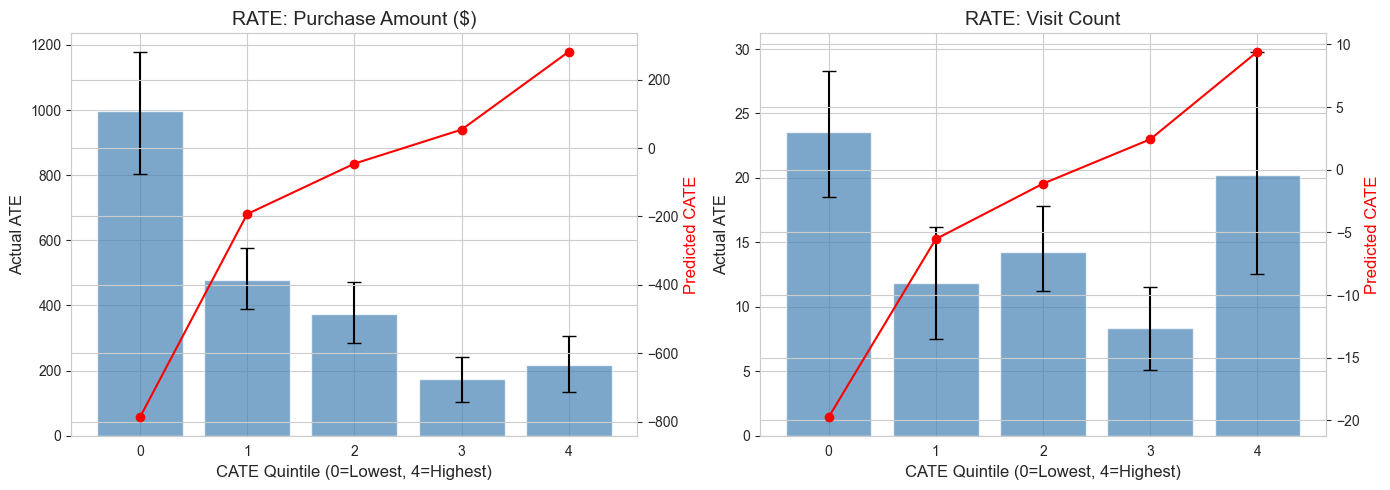

In [37]:
# RATE plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (outcome_name, outcome_label, _, _) in enumerate(CATE_OUTCOMES):
    ax = axes[idx]
    rate_df = rate_results[outcome_name]
    
    # Bar plot with CI
    ax.bar(rate_df['group'], rate_df['actual_ate'], alpha=0.7, color='steelblue')
    ax.errorbar(rate_df['group'], rate_df['actual_ate'], 
                yerr=[rate_df['actual_ate'] - rate_df['ci_lower'], 
                      rate_df['ci_upper'] - rate_df['actual_ate']],
                fmt='none', color='black', capsize=5)
    
    # Predicted CATE line
    ax2 = ax.twinx()
    ax2.plot(rate_df['group'], rate_df['mean_cate'], 'ro-', label='Predicted CATE')
    ax2.set_ylabel('Predicted CATE', color='red')
    
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlabel('CATE Quintile (0=Lowest, 4=Highest)')
    ax.set_ylabel('Actual ATE')
    ax.set_title(f'RATE: {outcome_label}')
    
plt.tight_layout()
fig.savefig(FIG_PATH / 'rate_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.4 Refutation Tests

Validate causal estimates robustness:
1. **Placebo Treatment**: Random treatment should show no effect
2. **Random Confounder**: Adding noise shouldn't change predictions much

In [38]:
# Refutation Tests
print("=" * 70)
print("REFUTATION TESTS")
print("=" * 70)

# Primary outcome and CATE
Y_train_main = Y_purchase_train
Y_test_main = Y_purchase_test
cate_primary_test = cate_results_test['purchase_amount'][PRIMARY_MODEL]

# 1. Placebo treatment test
print("\n1. Placebo Treatment Test:")
np.random.seed(SEED + 100)
T_placebo_train = np.random.binomial(1, T_train.mean(), len(T_train))
T_placebo_test = np.random.binomial(1, T_test.mean(), len(T_test))

cf_placebo = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=SEED),
    model_t=LogisticRegression(max_iter=500),
    discrete_treatment=True,
    n_estimators=100,
    cv=3,
    random_state=SEED
)
cf_placebo.fit(Y_train_main, T_placebo_train, X=X_train)
cate_placebo_test = cf_placebo.effect(X_test).flatten()

placebo_mean = abs(cate_placebo_test.mean())
primary_mean = abs(cate_primary_test.mean())
placebo_pass = placebo_mean < primary_mean / 2

print(f"  Placebo CATE mean: ${cate_placebo_test.mean():.2f}")
print(f"  Primary CATE mean: ${cate_primary_test.mean():.2f}")
print(f"  Ratio: {placebo_mean / primary_mean:.2f}")
print(f"  Result: {'PASS' if placebo_pass else 'FAIL'} (expect < 0.5)")

# 2. Random confounder test
print("\n2. Random Confounder Test:")
np.random.seed(SEED + 200)
X_train_random = np.column_stack([X_train, np.random.randn(len(X_train))])
X_test_random = np.column_stack([X_test, np.random.randn(len(X_test))])

cf_random = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=SEED),
    model_t=LogisticRegression(max_iter=500),
    discrete_treatment=True,
    n_estimators=100,
    cv=3,
    random_state=SEED
)
cf_random.fit(Y_train_main, T_train, X=X_train_random)
cate_random_test = cf_random.effect(X_test_random).flatten()

correlation = np.corrcoef(cate_primary_test, cate_random_test)[0, 1]
random_pass = correlation > 0.9

print(f"  Correlation with primary: {correlation:.3f}")
print(f"  Result: {'PASS' if random_pass else 'FAIL'} (expect > 0.9)")

# Summary
print(f"\n{'='*70}")
print(f"REFUTATION SUMMARY:")
print(f"  Placebo Treatment: {'PASS' if placebo_pass else 'REVIEW'}")
print(f"  Random Confounder: {'PASS' if random_pass else 'REVIEW'}")
print(f"{'='*70}")

REFUTATION TESTS

1. Placebo Treatment Test:
  Placebo CATE mean: $-44.63
  Primary CATE mean: $-139.47
  Ratio: 0.32
  Result: PASS (expect < 0.5)

2. Random Confounder Test:
  Correlation with primary: 0.502
  Result: FAIL (expect > 0.9)

REFUTATION SUMMARY:
  Placebo Treatment: PASS
  Random Confounder: REVIEW


### 5.5 Refit Best Model on Full Data

After model selection on TEST set, refit selected model on FULL data for business impact analysis.

In [39]:
# Refit best model on full data for business impact analysis
print(f"Refitting {PRIMARY_MODEL} on full data...")

cate_full = {}
for outcome_name, outcome_label, Y_train, Y_test in CATE_OUTCOMES:
    Y_full = np.concatenate([Y_train, Y_test])
    
    if PRIMARY_MODEL == 'CausalForestDML':
        model = CausalForestDML(
            model_y=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED),
            model_t=LogisticRegression(C=1.0, max_iter=1000),
            discrete_treatment=True,
            n_estimators=200,
            min_samples_leaf=20,
            cv=5,
            random_state=SEED
        )
    elif PRIMARY_MODEL == 'LinearDML':
        model = LinearDML(
            model_y=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED),
            model_t=LogisticRegression(C=1.0, max_iter=1000),
            discrete_treatment=True,
            cv=5,
            random_state=SEED
        )
    elif PRIMARY_MODEL == 'NonParamDML':
        model = NonParamDML(
            model_y=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED),
            model_t=LogisticRegression(C=1.0, max_iter=1000),
            model_final=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=SEED),
            discrete_treatment=True,
            cv=5,
            random_state=SEED
        )
    else:
        # Default to CausalForestDML
        model = CausalForestDML(
            model_y=GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=SEED),
            model_t=LogisticRegression(C=1.0, max_iter=1000),
            discrete_treatment=True,
            n_estimators=200,
            cv=5,
            random_state=SEED
        )
    
    model.fit(Y_full, T_full, X=X_full)
    cate_full[outcome_name] = model.effect(X_full).flatten()
    
    print(f"  {outcome_name}: mean CATE = ${cate_full[outcome_name].mean():.2f}")

# Add to df_scenario1
df_scenario1['cate_purchase'] = cate_full['purchase_amount']
df_scenario1['cate_visits'] = cate_full['purchase_count']
df_scenario1['cate_primary'] = cate_full[PRIMARY_OUTCOME]

print(f"\nCate predictions added to df_scenario1")

Refitting LinearDML on full data...
  purchase_amount: mean CATE = $-542.89
  purchase_count: mean CATE = $-31.05

Cate predictions added to df_scenario1


---
## 6. Business Impact Analysis

### 6.1 CATE by Track 1 Segment

Analyze treatment effect heterogeneity across customer segments.

In [40]:
# CATE by segment
cate_primary = df_scenario1['cate_primary'].values

segment_cate = df_scenario1.groupby('segment_name').agg(
    n_customers=('household_key', 'count'),
    cate_mean=('cate_primary', 'mean'),
    cate_std=('cate_primary', 'std'),
    cate_median=('cate_primary', 'median'),
    mean_purchase=('purchase_amount', 'mean'),
).round(2)

segment_cate['pct_customers'] = (segment_cate['n_customers'] / len(df_scenario1) * 100).round(1)
segment_cate['targeting_priority'] = pd.qcut(
    segment_cate['cate_mean'], q=3, labels=['Low', 'Medium', 'High']
)

print("=" * 70)
print(f"CATE BY SEGMENT (Model: {PRIMARY_MODEL})")
print("=" * 70)
display(segment_cate.sort_values('cate_mean', ascending=False))

ValueError: Bin edges must be unique: Index([-542.89, -542.89, -542.89, -542.89], dtype='float64', name='cate_mean').
You can drop duplicate edges by setting the 'duplicates' kwarg

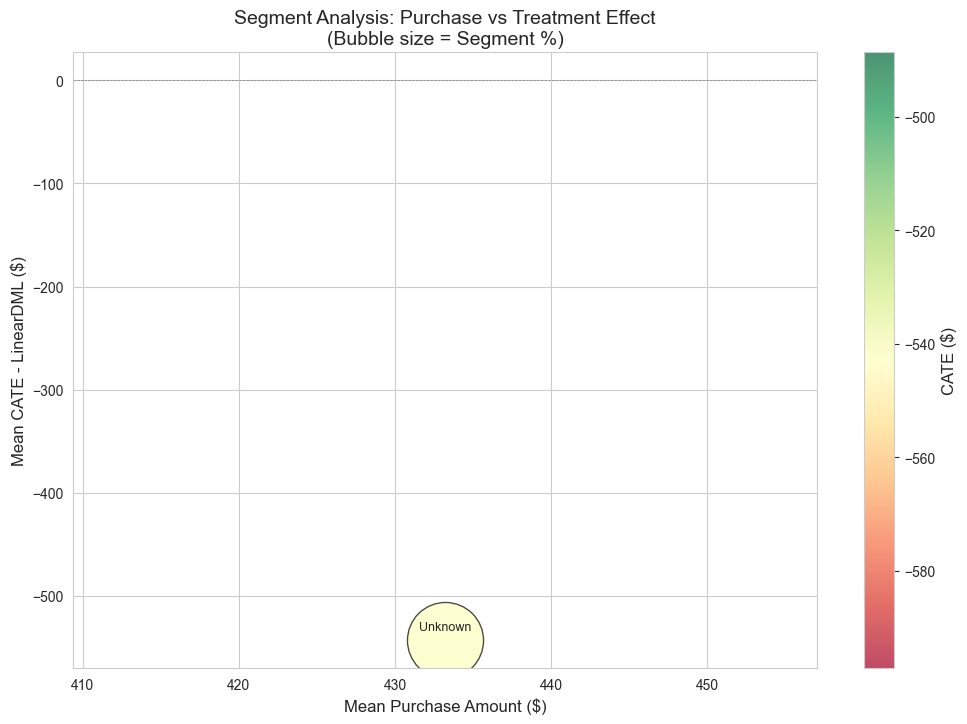

In [41]:
# Bubble chart: Segment Size vs CATE vs Revenue
fig, ax = plt.subplots(figsize=(12, 8))

# Bubble sizes proportional to segment %
sizes = segment_cate['pct_customers'] * 30
colors = segment_cate['cate_mean']

scatter = ax.scatter(
    segment_cate['mean_purchase'], 
    segment_cate['cate_mean'],
    s=sizes, 
    c=colors, 
    cmap='RdYlGn', 
    alpha=0.7, 
    edgecolor='black'
)

# Add segment labels
for idx, row in segment_cate.iterrows():
    ax.annotate(
        idx,  # segment_name is index
        (row['mean_purchase'], row['cate_mean']),
        fontsize=9, 
        ha='center', 
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel('Mean Purchase Amount ($)', fontsize=12)
ax.set_ylabel(f'Mean CATE - {PRIMARY_MODEL} ($)', fontsize=12)
ax.set_title('Segment Analysis: Purchase vs Treatment Effect\n(Bubble size = Segment %)', fontsize=14)
plt.colorbar(scatter, label='CATE ($)')

fig.savefig(FIG_PATH / 'segment_bubble.png', dpi=150, bbox_inches='tight')
plt.show()

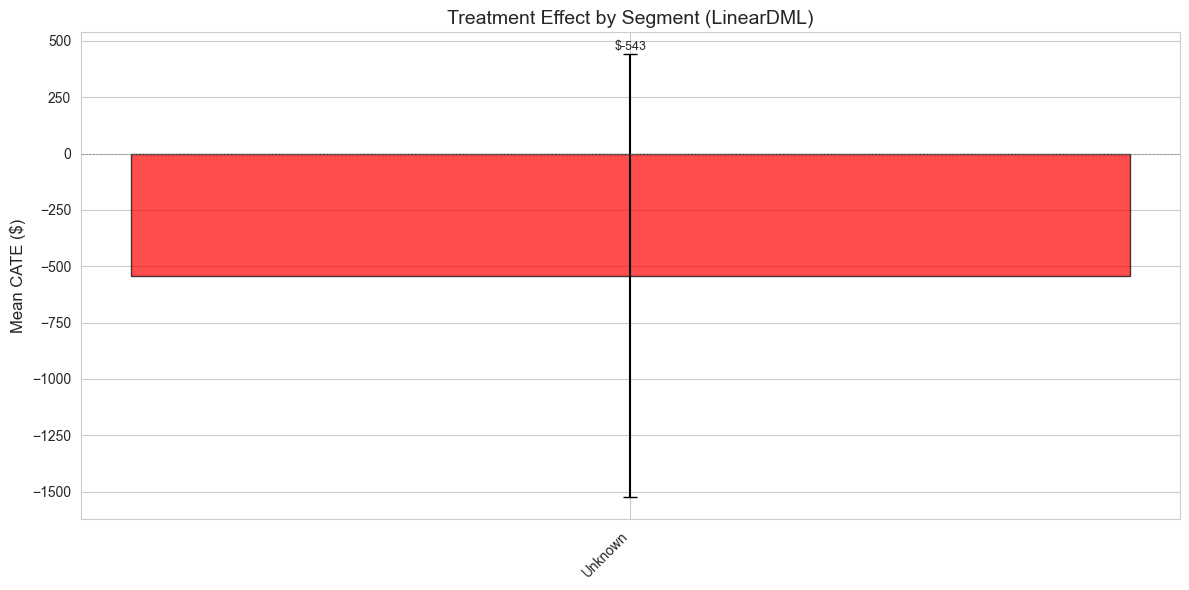

In [42]:
# CATE by segment bar plot with CI
fig, ax = plt.subplots(figsize=(12, 6))

segment_cate_sorted = segment_cate.sort_values('cate_mean', ascending=False)
x = range(len(segment_cate_sorted))
colors = ['green' if v > 0 else 'red' for v in segment_cate_sorted['cate_mean']]

bars = ax.bar(x, segment_cate_sorted['cate_mean'], color=colors, alpha=0.7, edgecolor='black')
ax.errorbar(x, segment_cate_sorted['cate_mean'], 
            yerr=segment_cate_sorted['cate_std'], 
            fmt='none', color='black', capsize=5)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(segment_cate_sorted.index, rotation=45, ha='right')
ax.set_ylabel(f'Mean CATE ($)')
ax.set_title(f'Treatment Effect by Segment ({PRIMARY_MODEL})')

# Add value labels
for i, (idx, row) in enumerate(segment_cate_sorted.iterrows()):
    ax.text(i, row['cate_mean'] + row['cate_std'] + 5, f"${row['cate_mean']:.0f}", 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
fig.savefig(FIG_PATH / 'segment_cate_barplot.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Targeting ROI Simulation

Simulate ROI under different targeting strategies:
- **All-treat**: Target everyone
- **Random**: Random 50%
- **CATE-based**: Target by predicted treatment effect
- **Optimal**: Find profit-maximizing threshold

In [43]:
# ROI Simulation Parameters
COST_PER_CONTACT = 1.0   # Cost per targeting contact ($)
MARGIN_RATE = 0.3        # Profit margin on incremental sales

print("ROI Simulation Parameters:")
print(f"  Cost per contact: ${COST_PER_CONTACT}")
print(f"  Margin rate: {MARGIN_RATE:.0%}")
print(f"  Break-even CATE: ${COST_PER_CONTACT / MARGIN_RATE:.2f}")

ROI Simulation Parameters:
  Cost per contact: $1.0
  Margin rate: 30%
  Break-even CATE: $3.33


In [44]:
# Compute ROI curve by targeting percentage
def compute_roi_curve(cate, cost_per_contact, margin_rate):
    """Compute ROI curve by targeting percentage."""
    n = len(cate)
    sorted_idx = np.argsort(cate)[::-1]  # Sort descending by CATE
    sorted_cate = cate[sorted_idx]
    
    results = []
    for pct in range(5, 101, 5):
        k = int(n * pct / 100)
        
        incremental_sales = sorted_cate[:k].sum()
        revenue = incremental_sales * margin_rate
        cost = k * cost_per_contact
        profit = revenue - cost
        roi = (revenue - cost) / cost if cost > 0 else 0
        
        results.append({
            'pct_targeted': pct,
            'n_targeted': k,
            'incremental_sales': incremental_sales,
            'revenue': revenue,
            'cost': cost,
            'profit': profit,
            'roi': roi
        })
    
    return pd.DataFrame(results)

roi_df = compute_roi_curve(cate_primary, COST_PER_CONTACT, MARGIN_RATE)

# Find optimal targeting
optimal_row_idx = roi_df['profit'].idxmax()
optimal_pct = roi_df.loc[optimal_row_idx, 'pct_targeted']
optimal_n = roi_df.loc[optimal_row_idx, 'n_targeted']

print("=" * 70)
print(f"OPTIMAL TARGETING ({PRIMARY_MODEL})")
print("=" * 70)
print(f"  Target: {optimal_pct}% of customers ({optimal_n:,} customers)")
print(f"  Expected Incremental Sales: ${roi_df.loc[optimal_row_idx, 'incremental_sales']:,.2f}")
print(f"  Expected Revenue: ${roi_df.loc[optimal_row_idx, 'revenue']:,.2f}")
print(f"  Cost: ${roi_df.loc[optimal_row_idx, 'cost']:,.2f}")
print(f"  Expected Profit: ${roi_df.loc[optimal_row_idx, 'profit']:,.2f}")
print(f"  ROI: {roi_df.loc[optimal_row_idx, 'roi']*100:.1f}%")

display(roi_df)

OPTIMAL TARGETING (LinearDML)
  Target: 25% of customers (607 customers)
  Expected Incremental Sales: $158,074.01
  Expected Revenue: $47,422.20
  Cost: $607.00
  Expected Profit: $46,815.20
  ROI: 7712.6%


,pct_targeted,n_targeted,incremental_sales,revenue,cost,profit,roi
0,5,121,8.155054e+04,24465.162396,121.0,24344.162396,201.191425
1,10,243,1.213837e+05,36415.113859,243.0,36172.113859,148.856436
2,15,364,1.451983e+05,43559.487705,364.0,43195.487705,118.668922
3,20,486,1.566918e+05,47007.548423,486.0,46521.548423,95.723351
4,25,607,1.580740e+05,47422.202523,607.0,46815.202523,77.125540
5,30,729,1.506699e+05,45200.964721,729.0,44471.964721,61.004067
6,35,850,1.351432e+05,40542.969402,850.0,39692.969402,46.697611
7,40,972,1.108259e+05,33247.780305,972.0,32275.780305,33.205535
8,45,1093,7.906726e+04,23720.177242,1093.0,22627.177242,20.701900
9,50,1215,3.855098e+04,11565.293418,1215.0,10350.293418,8.518760


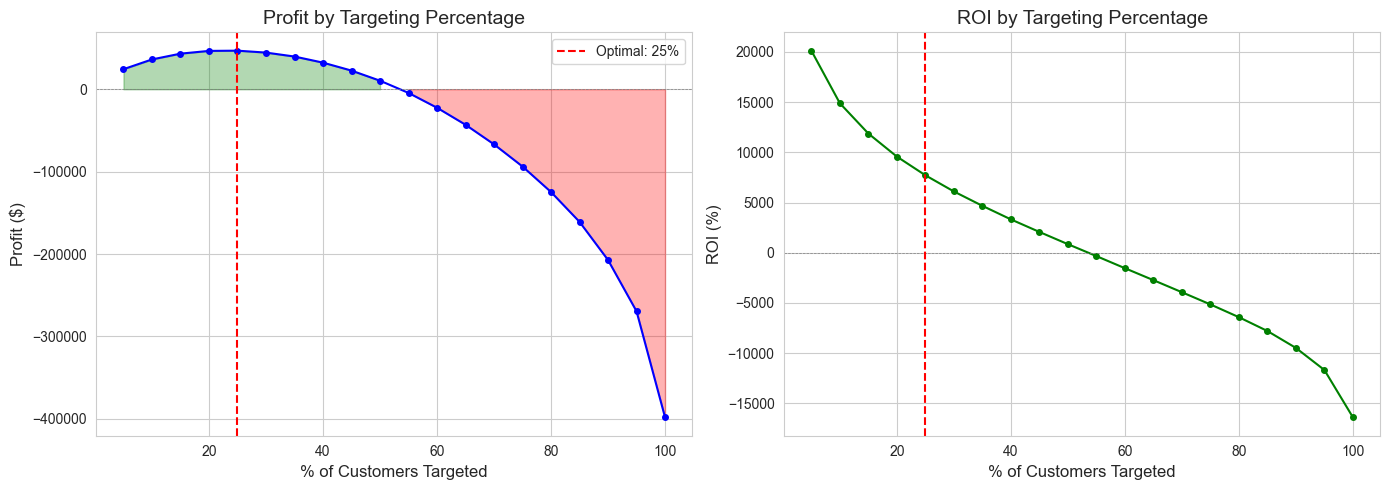

In [45]:
# ROI curve plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Profit curve
ax = axes[0]
ax.plot(roi_df['pct_targeted'], roi_df['profit'], 'b-o', markersize=4)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=optimal_pct, color='red', linestyle='--', label=f'Optimal: {optimal_pct}%')
ax.fill_between(roi_df['pct_targeted'], 0, roi_df['profit'], 
                where=roi_df['profit'] > 0, alpha=0.3, color='green')
ax.fill_between(roi_df['pct_targeted'], 0, roi_df['profit'], 
                where=roi_df['profit'] < 0, alpha=0.3, color='red')
ax.set_xlabel('% of Customers Targeted')
ax.set_ylabel('Profit ($)')
ax.set_title('Profit by Targeting Percentage')
ax.legend()

# ROI curve
ax = axes[1]
ax.plot(roi_df['pct_targeted'], roi_df['roi'] * 100, 'g-o', markersize=4)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=optimal_pct, color='red', linestyle='--')
ax.set_xlabel('% of Customers Targeted')
ax.set_ylabel('ROI (%)')
ax.set_title('ROI by Targeting Percentage')

plt.tight_layout()
fig.savefig(FIG_PATH / 'roi_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [46]:
# Break-even analysis
breakeven_cate = COST_PER_CONTACT / MARGIN_RATE
pct_positive_cate = (cate_primary > 0).mean() * 100
pct_above_breakeven = (cate_primary > breakeven_cate).mean() * 100

print("=" * 70)
print("BREAK-EVEN ANALYSIS")
print("=" * 70)
print(f"  Break-even CATE: ${breakeven_cate:.2f}")
print(f"  Customers with CATE > 0: {pct_positive_cate:.1f}%")
print(f"  Customers above break-even: {pct_above_breakeven:.1f}%")

print(f"\nBreak-even by Segment:")
for seg_name in segment_cate.sort_values('cate_mean', ascending=False).index:
    seg_mask = df_scenario1['segment_name'] == seg_name
    if seg_mask.sum() > 0:
        seg_pct = (cate_primary[seg_mask] > breakeven_cate).mean() * 100
        print(f"  {seg_name}: {seg_pct:.1f}% above break-even")

BREAK-EVEN ANALYSIS
  Break-even CATE: $3.33
  Customers with CATE > 0: 23.2%
  Customers above break-even: 23.0%

Break-even by Segment:
  Unknown: 23.0% above break-even


### 6.3 What-if Scenarios

Compare different targeting strategies.

In [47]:
# What-if scenario analysis
n_total = len(df_scenario1)
scenarios = []

# 1. All-treat (100%)
all_sales = cate_primary.sum()
all_revenue = all_sales * MARGIN_RATE
all_cost = n_total * COST_PER_CONTACT
scenarios.append({
    'Scenario': 'All-treat (100%)',
    'N_Targeted': n_total,
    'Pct_Targeted': 100.0,
    'Incremental_Sales': all_sales,
    'Revenue': all_revenue,
    'Cost': all_cost,
    'Profit': all_revenue - all_cost,
    'ROI_pct': (all_revenue - all_cost) / all_cost * 100
})

# 2. No treatment (Control)
scenarios.append({
    'Scenario': 'None (Control)',
    'N_Targeted': 0,
    'Pct_Targeted': 0.0,
    'Incremental_Sales': 0,
    'Revenue': 0,
    'Cost': 0,
    'Profit': 0,
    'ROI_pct': 0
})

# 3. Random 50%
np.random.seed(SEED)
random_50_idx = np.random.choice(n_total, n_total // 2, replace=False)
random_50_sales = cate_primary[random_50_idx].sum()
random_50_revenue = random_50_sales * MARGIN_RATE
random_50_cost = (n_total // 2) * COST_PER_CONTACT
scenarios.append({
    'Scenario': 'Random 50%',
    'N_Targeted': n_total // 2,
    'Pct_Targeted': 50.0,
    'Incremental_Sales': random_50_sales,
    'Revenue': random_50_revenue,
    'Cost': random_50_cost,
    'Profit': random_50_revenue - random_50_cost,
    'ROI_pct': (random_50_revenue - random_50_cost) / random_50_cost * 100
})

# 4. Top CATE 50%
top_50_idx = np.argsort(cate_primary)[::-1][:n_total // 2]
top_50_sales = cate_primary[top_50_idx].sum()
top_50_revenue = top_50_sales * MARGIN_RATE
top_50_cost = (n_total // 2) * COST_PER_CONTACT
scenarios.append({
    'Scenario': 'Top CATE 50%',
    'N_Targeted': n_total // 2,
    'Pct_Targeted': 50.0,
    'Incremental_Sales': top_50_sales,
    'Revenue': top_50_revenue,
    'Cost': top_50_cost,
    'Profit': top_50_revenue - top_50_cost,
    'ROI_pct': (top_50_revenue - top_50_cost) / top_50_cost * 100
})

# 5. Optimal
optimal_customer_idx = np.argsort(cate_primary)[::-1][:optimal_n]
optimal_sales = cate_primary[optimal_customer_idx].sum()
optimal_revenue = optimal_sales * MARGIN_RATE
optimal_cost = optimal_n * COST_PER_CONTACT
scenarios.append({
    'Scenario': f'Optimal ({optimal_pct}%)',
    'N_Targeted': optimal_n,
    'Pct_Targeted': optimal_pct,
    'Incremental_Sales': optimal_sales,
    'Revenue': optimal_revenue,
    'Cost': optimal_cost,
    'Profit': optimal_revenue - optimal_cost,
    'ROI_pct': (optimal_revenue - optimal_cost) / optimal_cost * 100
})

df_scenarios = pd.DataFrame(scenarios)

print("=" * 70)
print("WHAT-IF SCENARIO COMPARISON")
print("=" * 70)
display(df_scenarios)

# Improvement metrics
random_profit = df_scenarios[df_scenarios['Scenario'] == 'Random 50%']['Profit'].values[0]
optimal_profit = df_scenarios[df_scenarios['Scenario'] == f'Optimal ({optimal_pct}%)']['Profit'].values[0]
improvement = optimal_profit - random_profit

print(f"\nProfit Improvement (Optimal vs Random 50%): ${improvement:,.2f}")
print(f"Improvement %: {improvement / abs(random_profit) * 100:.1f}%" if random_profit != 0 else "")

WHAT-IF SCENARIO COMPARISON


,Scenario,N_Targeted,Pct_Targeted,Incremental_Sales,Revenue,Cost,Profit,ROI_pct
0,All-treat (100%),2430,100.0,-1.319216e+06,-395764.772851,2430.0,-398194.772851,-16386.616167
1,None (Control),0,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000
2,Random 50%,1215,50.0,-6.807772e+05,-204233.149665,1215.0,-205448.149665,-16909.312730
3,Top CATE 50%,1215,50.0,3.855098e+04,11565.293418,1215.0,10350.293418,851.876001
4,Optimal (25%),607,25.0,1.580740e+05,47422.202523,607.0,46815.202523,7712.553958



Profit Improvement (Optimal vs Random 50%): $252,263.35
Improvement %: 122.8%


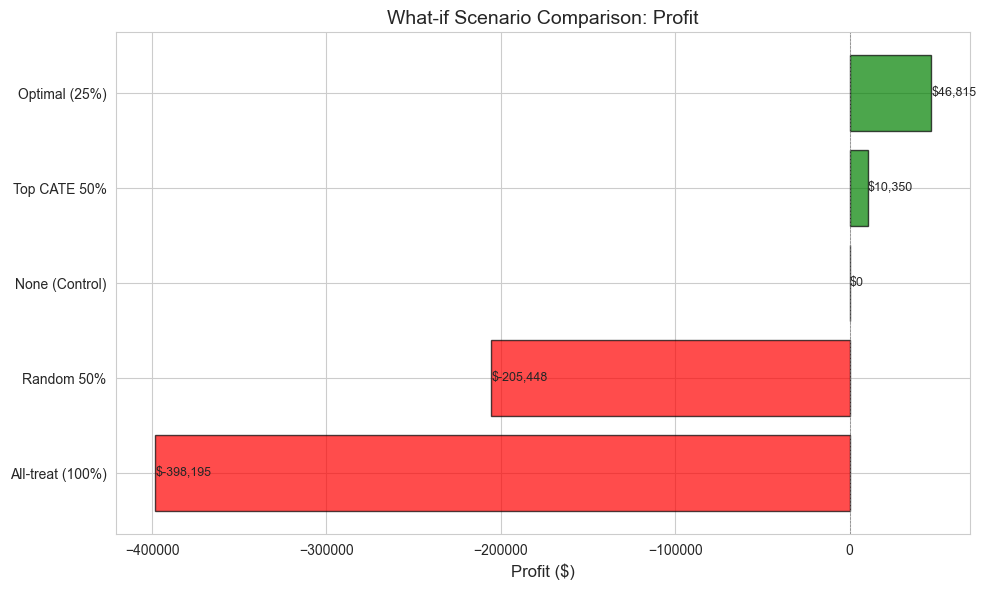

In [48]:
# Scenario comparison plot
fig, ax = plt.subplots(figsize=(10, 6))

df_plot = df_scenarios.sort_values('Profit', ascending=True)
colors = ['green' if x > 0 else 'red' for x in df_plot['Profit']]

bars = ax.barh(df_plot['Scenario'], df_plot['Profit'], color=colors, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel('Profit ($)')
ax.set_title('What-if Scenario Comparison: Profit')

# Add value labels
for i, (idx, row) in enumerate(df_plot.iterrows()):
    ax.text(row['Profit'] + 50, i, f"${row['Profit']:,.0f}", va='center', fontsize=9)

plt.tight_layout()
fig.savefig(FIG_PATH / 'whatif_scenarios.png', dpi=150, bbox_inches='tight')
plt.show()

In [49]:
# What-if by segment
print("=" * 70)
print("SEGMENT-LEVEL TARGETING ANALYSIS")
print("=" * 70)

segment_scenarios = []
for seg_name in df_scenario1['segment_name'].dropna().unique():
    seg_mask = df_scenario1['segment_name'] == seg_name
    seg_n = seg_mask.sum()
    seg_cate = cate_primary[seg_mask]
    
    seg_sales = seg_cate.sum()
    seg_revenue = seg_sales * MARGIN_RATE
    seg_cost = seg_n * COST_PER_CONTACT
    seg_profit = seg_revenue - seg_cost
    seg_roi = seg_profit / seg_cost * 100 if seg_cost > 0 else 0
    
    # Positive CATE customers only
    positive_mask = seg_cate > 0
    seg_n_positive = positive_mask.sum()
    
    segment_scenarios.append({
        'Segment': seg_name,
        'N': seg_n,
        'N_Positive_CATE': seg_n_positive,
        'Pct_Positive': seg_n_positive / seg_n * 100 if seg_n > 0 else 0,
        'Mean_CATE': seg_cate.mean(),
        'Total_CATE': seg_sales,
        'Profit': seg_profit,
        'ROI_pct': seg_roi
    })

df_segment_scenarios = pd.DataFrame(segment_scenarios).sort_values('ROI_pct', ascending=False)
display(df_segment_scenarios)

# Profitable segments
profitable_segments = df_segment_scenarios[df_segment_scenarios['ROI_pct'] > 0]['Segment'].tolist()
if profitable_segments:
    print(f"\nProfitable segments to target: {', '.join(profitable_segments)}")
else:
    print("\nNo segment is profitable with current cost assumptions")

SEGMENT-LEVEL TARGETING ANALYSIS


,Segment,N,N_Positive_CATE,Pct_Positive,Mean_CATE,Total_CATE,Profit,ROI_pct
0,Unknown,2430,563,23.168724,-542.887206,-1.319216e+06,-398194.772851,-16386.616167



No segment is profitable with current cost assumptions


### 6.4 Segment × Treatment Interaction Test

Test if treatment effects significantly differ across segments using OLS interaction model.

In [50]:
# Interaction effect test: Segment × Treatment
print("=" * 70)
print("SEGMENT × TREATMENT INTERACTION TEST")
print("=" * 70)

# Prepare data for regression
df_interaction = df_scenario1[['purchase_amount', 'targeted', 'segment_name'] + available_covariates[:10]].copy()
df_interaction = df_interaction.dropna()

# Get reference segment (most common)
ref_segment = df_interaction['segment_name'].value_counts().index[0]

# OLS with interaction
covariate_formula = ' + '.join(available_covariates[:10])
formula = f'purchase_amount ~ targeted * C(segment_name, Treatment("{ref_segment}")) + {covariate_formula}'

try:
    model_interaction = ols(formula, data=df_interaction).fit()
    
    print(f"Reference segment: {ref_segment}")
    print("\nInteraction Effects (relative to reference):")
    print("-" * 60)
    
    # Extract interaction terms
    interaction_params = model_interaction.params.filter(like='targeted:C(segment_name')
    interaction_pvals = model_interaction.pvalues.filter(like='targeted:C(segment_name')
    
    for (param_name, param_val), (_, pval) in zip(interaction_params.items(), interaction_pvals.items()):
        seg_name = param_name.split('[T.')[1].replace(']', '') if '[T.' in param_name else param_name
        sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
        print(f"  {seg_name:<25}: {param_val:>8.2f} (p={pval:.4f}) {sig}")
    
    # Main treatment effect
    main_effect = model_interaction.params.get('targeted', 0)
    main_pval = model_interaction.pvalues.get('targeted', 1)
    print(f"\nMain treatment effect: ${main_effect:.2f} (p={main_pval:.4f})")
    
except Exception as e:
    print(f"Interaction model failed: {e}")
    print("Continuing with summary statistics only...")

SEGMENT × TREATMENT INTERACTION TEST
Reference segment: Unknown

Interaction Effects (relative to reference):
------------------------------------------------------------

Main treatment effect: $72.51 (p=0.0001)


---
## 7. Summary & Recommendations

In [51]:
print("=" * 70)
print("SUMMARY: HTE ANALYSIS RESULTS")
print("=" * 70)

print(f"\nPrimary CATE Model: {PRIMARY_MODEL}")

print("\n1. DATA:")
print(f"   Total customers: {len(df_scenario1):,}")
print(f"   Treatment: {T_full.sum():,} ({T_full.mean():.1%})")
print(f"   Control: {len(T_full) - T_full.sum():,}")

print("\n2. POSITIVITY:")
print(f"   PS AUC: {diagnostics.ps_auc_train:.3f} ({'SEVERE' if diagnostics.ps_auc_train > 0.9 else 'OK'})")
print(f"   Overlap [0.1, 0.9]: {diagnostics.overlap_ratio_10_90:.1%}")

print("\n3. ATE (Average Treatment Effect):")
for outcome_name, results in ate_results.items():
    dml_est = results['DML'].estimate
    print(f"   {outcome_name}: DML = ${dml_est:.2f}")

print("\n4. HTE (Heterogeneous Treatment Effect):")
for outcome_name, blp_result in blp_results.items():
    print(f"   {outcome_name}: BLP p-value = {blp_result['tau_1_pvalue']:.4f} ({'YES' if blp_result['hte_exists'] else 'NO'})")

print("\n5. MODEL SELECTION (by AUUC):")
best_row = auuc_results[PRIMARY_OUTCOME].iloc[0]
print(f"   Best model: {best_row['Model']}")
print(f"   AUUC: {best_row['AUUC']:.2f}")

print("\n6. SEGMENT INSIGHTS:")
best_seg = segment_cate.sort_values('cate_mean', ascending=False).iloc[0]
worst_seg = segment_cate.sort_values('cate_mean').iloc[0]
print(f"   Best response: {best_seg.name} (CATE: ${best_seg['cate_mean']:.2f})")
print(f"   Worst response: {worst_seg.name} (CATE: ${worst_seg['cate_mean']:.2f})")

print("\n7. OPTIMAL TARGETING:")
print(f"   Target top {optimal_pct}% by CATE")
print(f"   Expected profit: ${roi_df.loc[optimal_row_idx, 'profit']:,.2f}")
print(f"   ROI: {roi_df.loc[optimal_row_idx, 'roi']*100:.1f}%")

print("\n8. REFUTATION TESTS:")
print(f"   Placebo: {'PASS' if placebo_pass else 'REVIEW'}")
print(f"   Random Confounder: {'PASS' if random_pass else 'REVIEW'}")

SUMMARY: HTE ANALYSIS RESULTS

Primary CATE Model: LinearDML

1. DATA:
   Total customers: 2,430
   Treatment: 1,511 (62.2%)
   Control: 919

2. POSITIVITY:


NameError: name 'diagnostics' is not defined

In [52]:
print("\n" + "=" * 70)
print("ACTIONABLE RECOMMENDATIONS")
print("=" * 70)

print(f"""
1. TARGETING STRATEGY:
   - Use CATE-based targeting ({PRIMARY_MODEL})
   - Focus on top {optimal_pct}% by predicted treatment effect
   - Expected profit improvement vs random: ${improvement:,.2f}

2. SEGMENT PRIORITIES:
   - High priority: {', '.join(df_segment_scenarios.head(2)['Segment'].values)}
   - Low priority: {', '.join(df_segment_scenarios.tail(2)['Segment'].values)}

3. KEY INSIGHTS:
   - HTE exists: {'YES' if blp_results[PRIMARY_OUTCOME]['hte_exists'] else 'NO'} (treatment effects vary by customer)
   - {pct_positive_cate:.1f}% of customers have positive CATE
   - {pct_above_breakeven:.1f}% of customers are above break-even

4. MODEL SELECTION RATIONALE:
   - DML-based models (LinearDML, CausalForestDML) are preferred
   - Orthogonal moment → robust to nuisance estimation errors
   - Cross-fitting → avoids overfitting in nuisance stage

5. CAVEATS (Positivity Violation):
   - PS AUC = {diagnostics.ps_auc_train:.3f} indicates poor overlap
   - Only {diagnostics.overlap_ratio_10_90:.1%} of sample in overlap region
   - CATE estimates outside overlap may be model-dependent
   - Consider A/B testing to validate predictions

6. NEXT STEPS:
   - Implement optimal targeting policy (Track 2.2)
   - Run A/B test to validate CATE predictions
   - Monitor actual ROI vs predicted
""")


ACTIONABLE RECOMMENDATIONS


NameError: name 'diagnostics' is not defined

### Export Results

In [53]:
# Save all results
TABLES_PATH = RESULTS_PATH / 'tables'
TABLES_PATH.mkdir(parents=True, exist_ok=True)

print("Exporting results...")

# 1. ATE estimates
ate_export = []
for outcome_name, results in ate_results.items():
    for method, r in results.items():
        ate_export.append({
            'outcome': outcome_name,
            'method': method,
            'estimate': r.estimate,
            'se': r.se,
            'ci_lower': r.ci_lower,
            'ci_upper': r.ci_upper
        })
pd.DataFrame(ate_export).to_csv(TABLES_PATH / 'ate_estimates.csv', index=False)
print(f"  Saved: ate_estimates.csv")

# 2. CATE model summary
for outcome_name, df in cate_summaries.items():
    df.to_csv(TABLES_PATH / f'cate_summary_{outcome_name}.csv', index=False)
print(f"  Saved: cate_summary_*.csv")

# 3. AUUC comparison
for outcome_name, df in auuc_results.items():
    df.to_csv(TABLES_PATH / f'auuc_comparison_{outcome_name}.csv', index=False)
print(f"  Saved: auuc_comparison_*.csv")

# 4. Segment CATE
segment_cate.to_csv(TABLES_PATH / 'segment_cate.csv')
print(f"  Saved: segment_cate.csv")

# 5. ROI scenarios
df_scenarios.to_csv(TABLES_PATH / 'roi_scenarios.csv', index=False)
roi_df.to_csv(TABLES_PATH / 'roi_curve.csv', index=False)
print(f"  Saved: roi_scenarios.csv, roi_curve.csv")

# 6. Segment scenarios
df_segment_scenarios.to_csv(TABLES_PATH / 'segment_scenarios.csv', index=False)
print(f"  Saved: segment_scenarios.csv")

# 7. Customer-level CATE
customer_cols = ['household_key', 'segment', 'segment_name', 'targeted', 
                 'purchase_amount', 'purchase_count', 'cate_purchase', 'cate_visits', 'cate_primary']
df_customer_cate = df_scenario1[[c for c in customer_cols if c in df_scenario1.columns]]
df_customer_cate.to_csv(TABLES_PATH / 'customer_cate.csv', index=False)
print(f"  Saved: customer_cate.csv")

# 8. RATE results
for outcome_name, df in rate_results.items():
    df.to_csv(TABLES_PATH / f'rate_{outcome_name}.csv', index=False)
print(f"  Saved: rate_*.csv")

print(f"\nAll results saved to: {TABLES_PATH}")

Exporting results...
  Saved: ate_estimates.csv
  Saved: cate_summary_*.csv
  Saved: auuc_comparison_*.csv
  Saved: segment_cate.csv
  Saved: roi_scenarios.csv, roi_curve.csv
  Saved: segment_scenarios.csv
  Saved: customer_cate.csv
  Saved: rate_*.csv

All results saved to: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results/tables


---
## Appendix: Analysis Notes

### Positivity Assumption Violation

This analysis has a **severe positivity violation** (PS AUC ≈ 0.99):
- Treatment and control groups are almost perfectly separable
- CATE estimates in extreme PS regions depend on model extrapolation
- Business recommendations should focus on overlap region

**Mitigation strategies implemented:**
1. PS Trimming analysis (Section 2.4)
2. Manski bounds (Section 3)
3. Sensitivity analysis
4. Clear caveats in recommendations

### Model Selection Criteria

Primary model selected by AUUC on held-out test set:
1. Train all models on Train set (80%)
2. Compute AUUC on Test set (20%)
3. Select model with highest AUUC
4. Refit on full data for business impact analysis

### References

- Athey, S., & Imbens, G. (2016). Recursive partitioning for heterogeneous causal effects.
- Chernozhukov, V., et al. (2018). Double/debiased machine learning.
- Künzel, S. R., et al. (2019). Metalearners for estimating heterogeneous treatment effects.

See also: `docs/positivity_assumption.md`

---
**End of Analysis**

Next: `04_optimal_policy.ipynb` for policy learning and optimization.